In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Preparations

In [17]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("./data/chips.csv")
X = data.drop(columns=["class"]).to_numpy()
Y = data["class"].to_numpy()

all = train_test_split(X, Y, test_size=0.2, random_state=1337)
trainX, testX, trainY, testY = all

In [8]:
def brute_params(f, keys, ranges, i, **kwargs):
    if i >= len(keys):
        return f(**kwargs)
    best_score = 0
    best_m = None
    
    for j in ranges[i]:
        kwargs[keys[i]] = j
        m, score = brute_params(f, keys, ranges, i + 1, **kwargs)
        if score > best_score:
            best_score = score
            best_m = m
    return best_m, best_score

def model(classifier, trainX, testX, trainY, testY, const_args=dict(), **brute):
    def f(**kwargs):
        m = classifier(**(const_args | kwargs))
        m.fit(trainX, trainY)
        pred = m.predict(testX)
        accuracy = sum(testY[i] == cl for i, cl in enumerate(pred)) / len(testY)
        return m, accuracy
    return brute_params(f, list(brute.keys()), list(brute.values()), 0)

In [168]:
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

def brute_plot(classifier, data, param, values, **args):
    models = [model(classifier, *data, const_args=(args | {param: i}))[0] for i in values]
    acc_train = list([m.score(trainX, trainY) for m in models])
    acc_test = list([m.score(testX, testY) for m in models])
    print("best scores: train={0}, test={1}".format(max(acc_train), max(acc_test)))
    plt.figure(figsize=(15, 5), dpi=300)
    plt.plot(values, acc_train, "o-", values, acc_test, "o-")
    plt.legend(labels=["train", "test"])
    plt.ylabel('score')
    plt.xlabel(param)
    plt.show()

def space_plot(classifier, data, param, values, **args):
    res = np.array([np.array(model(classifier, *data, const_args=(args | {param: i})), dtype=object) for i in values], dtype=object)
    models, accuracy = res[:, 0], res[:, 1]
    n = len(accuracy)

    # layout
    columns = min(4, n)
    rows = int(np.ceil(n / columns))
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    plt.figure(figsize=(15, 10), dpi=300, tight_layout=True)

    # training and test points
    cm = plt.cm.BuPu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(rows, columns + 1, 1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.scatter(trainX[:, 0], trainX[:, 1], c=trainY, cmap=cm_bright, edgecolors="k")
    ax.scatter(testX[:, 0], testX[:, 1], c=testY, cmap=cm_bright, alpha=0.6, edgecolors="k")

    # classifiers
    for i, acc in enumerate(accuracy):
        ax = plt.subplot(rows, columns + 1, i + 2)
        DecisionBoundaryDisplay.from_estimator(
            models[i], X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(param + ": {0}".format(values[i]))
        ax.text(x_max - 0.3, y_min + 0.3, "acc: {0}".format(int(acc * 100) / 100), horizontalalignment="right")
        ax.scatter(trainX[:, 0], trainX[:, 1], c=trainY, cmap=cm_bright, edgecolors="k")
        ax.scatter(testX[:, 0], testX[:, 1], c=testY, cmap=cm_bright, alpha=0.6, edgecolors="k")

# Decision tree

In [11]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

accuracy: 0.875
max depth: 11


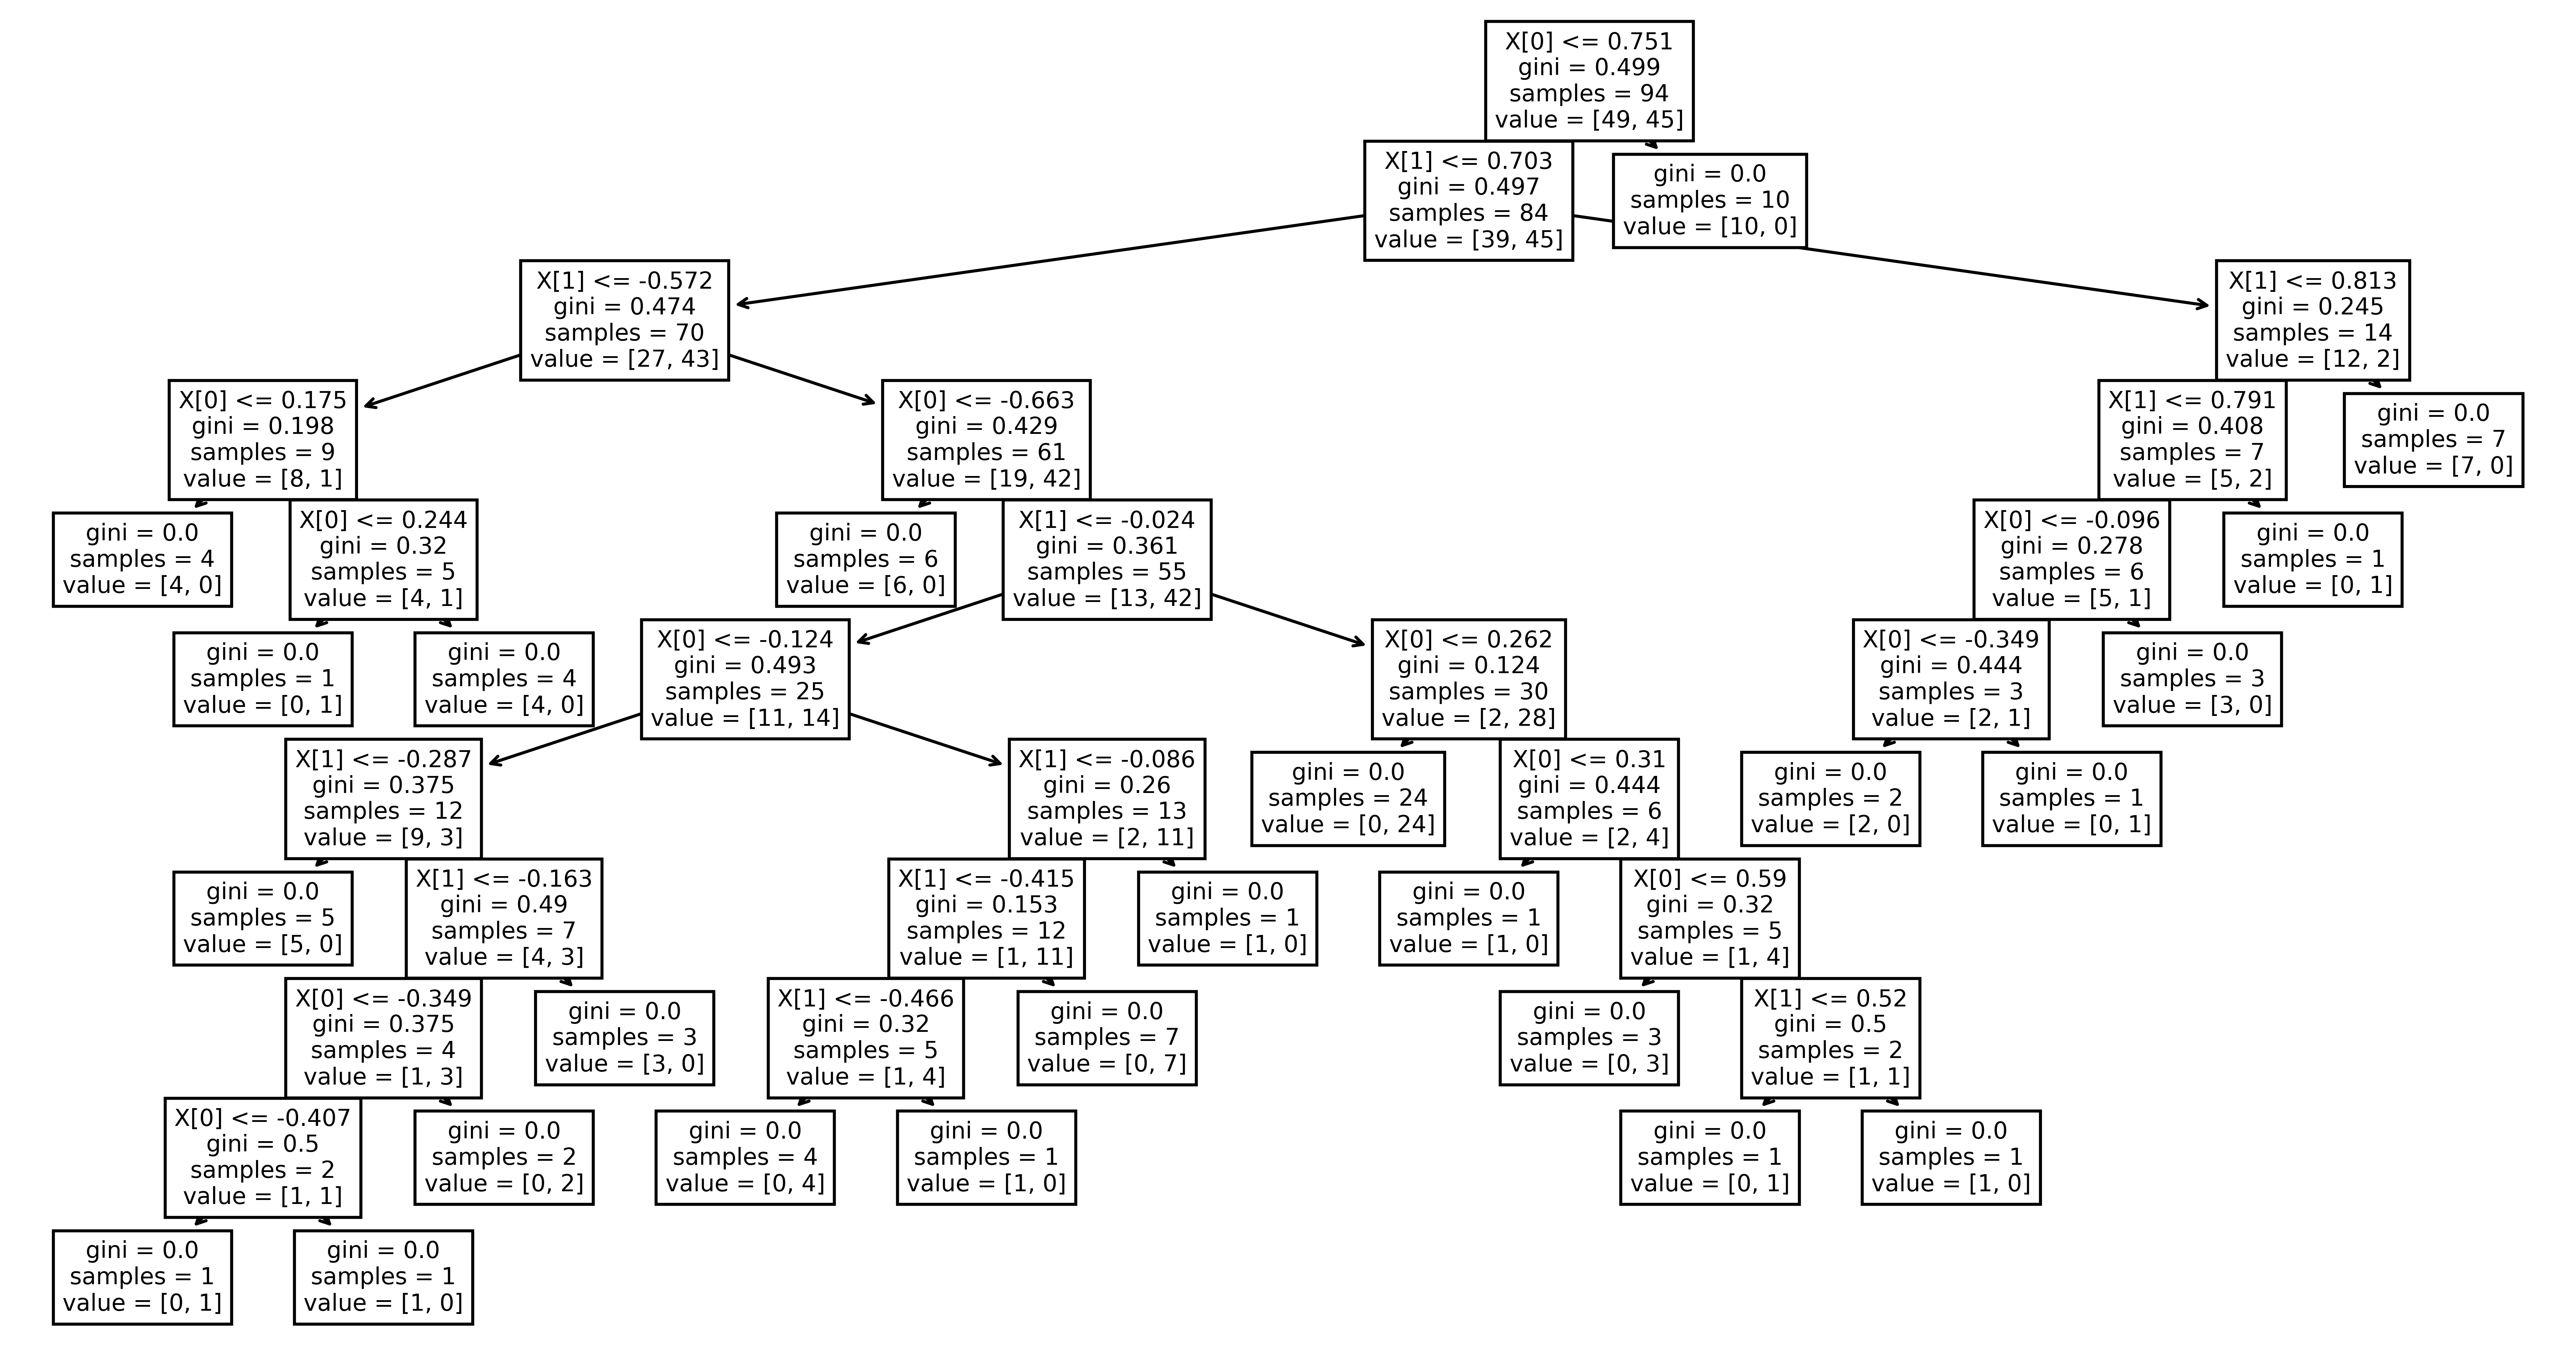

In [32]:
values = np.linspace(5, 100, 30, dtype=np.int32)
m, acc = model(DecisionTreeClassifier, *all, max_depth=values)
print("accuracy:", acc)
print("max depth:", m.max_depth)
plt.figure(figsize=(15, 8), dpi=600)
tree.plot_tree(m);

best scores: train=1.0, test=0.875


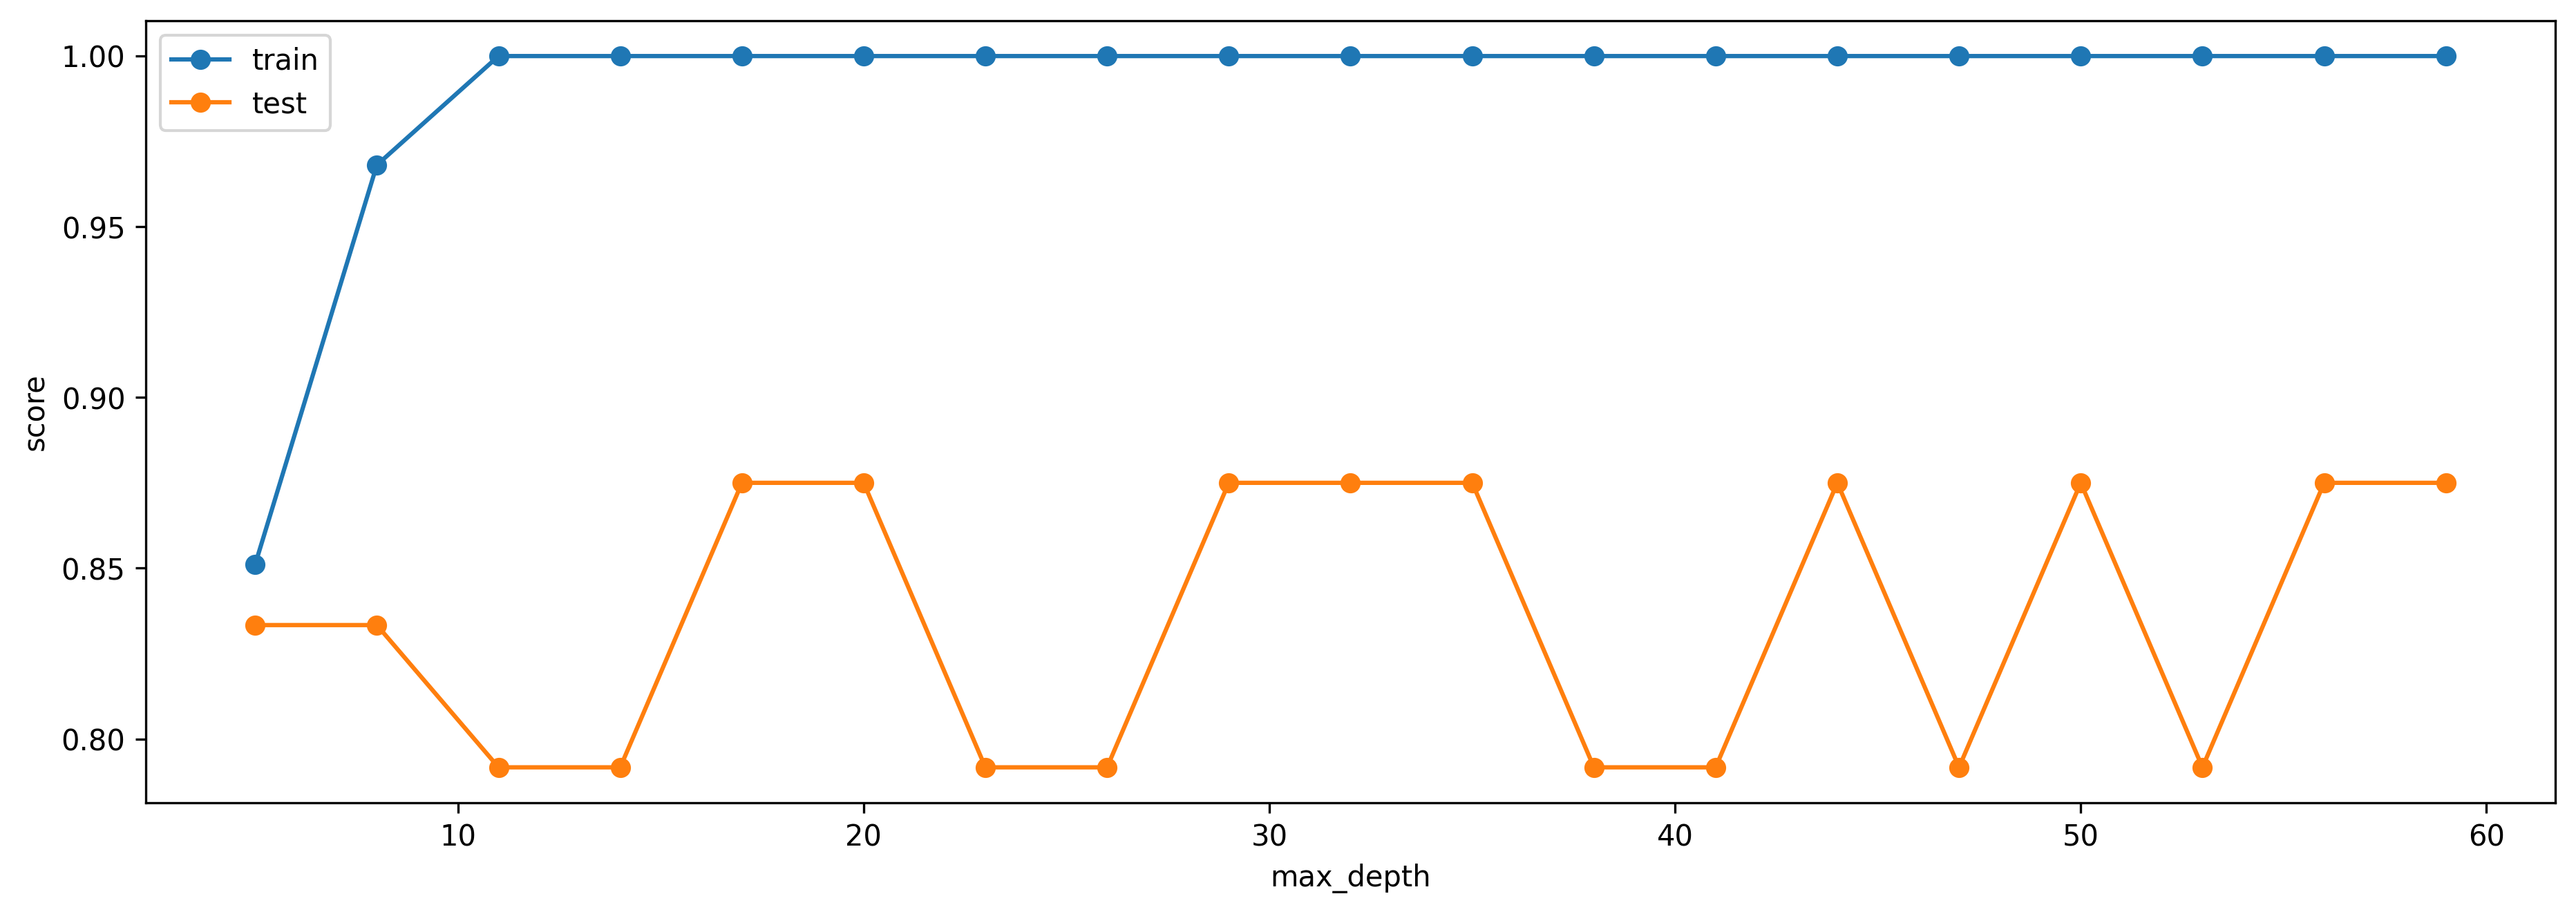

In [129]:
rng = np.random.RandomState(1337)
brute_plot(DecisionTreeClassifier, all, "max_depth", np.arange(5, 60, 3), random_state=rng)

# Random forest

In [111]:
from sklearn.ensemble import RandomForestClassifier

best scores: train=1.0, test=0.875


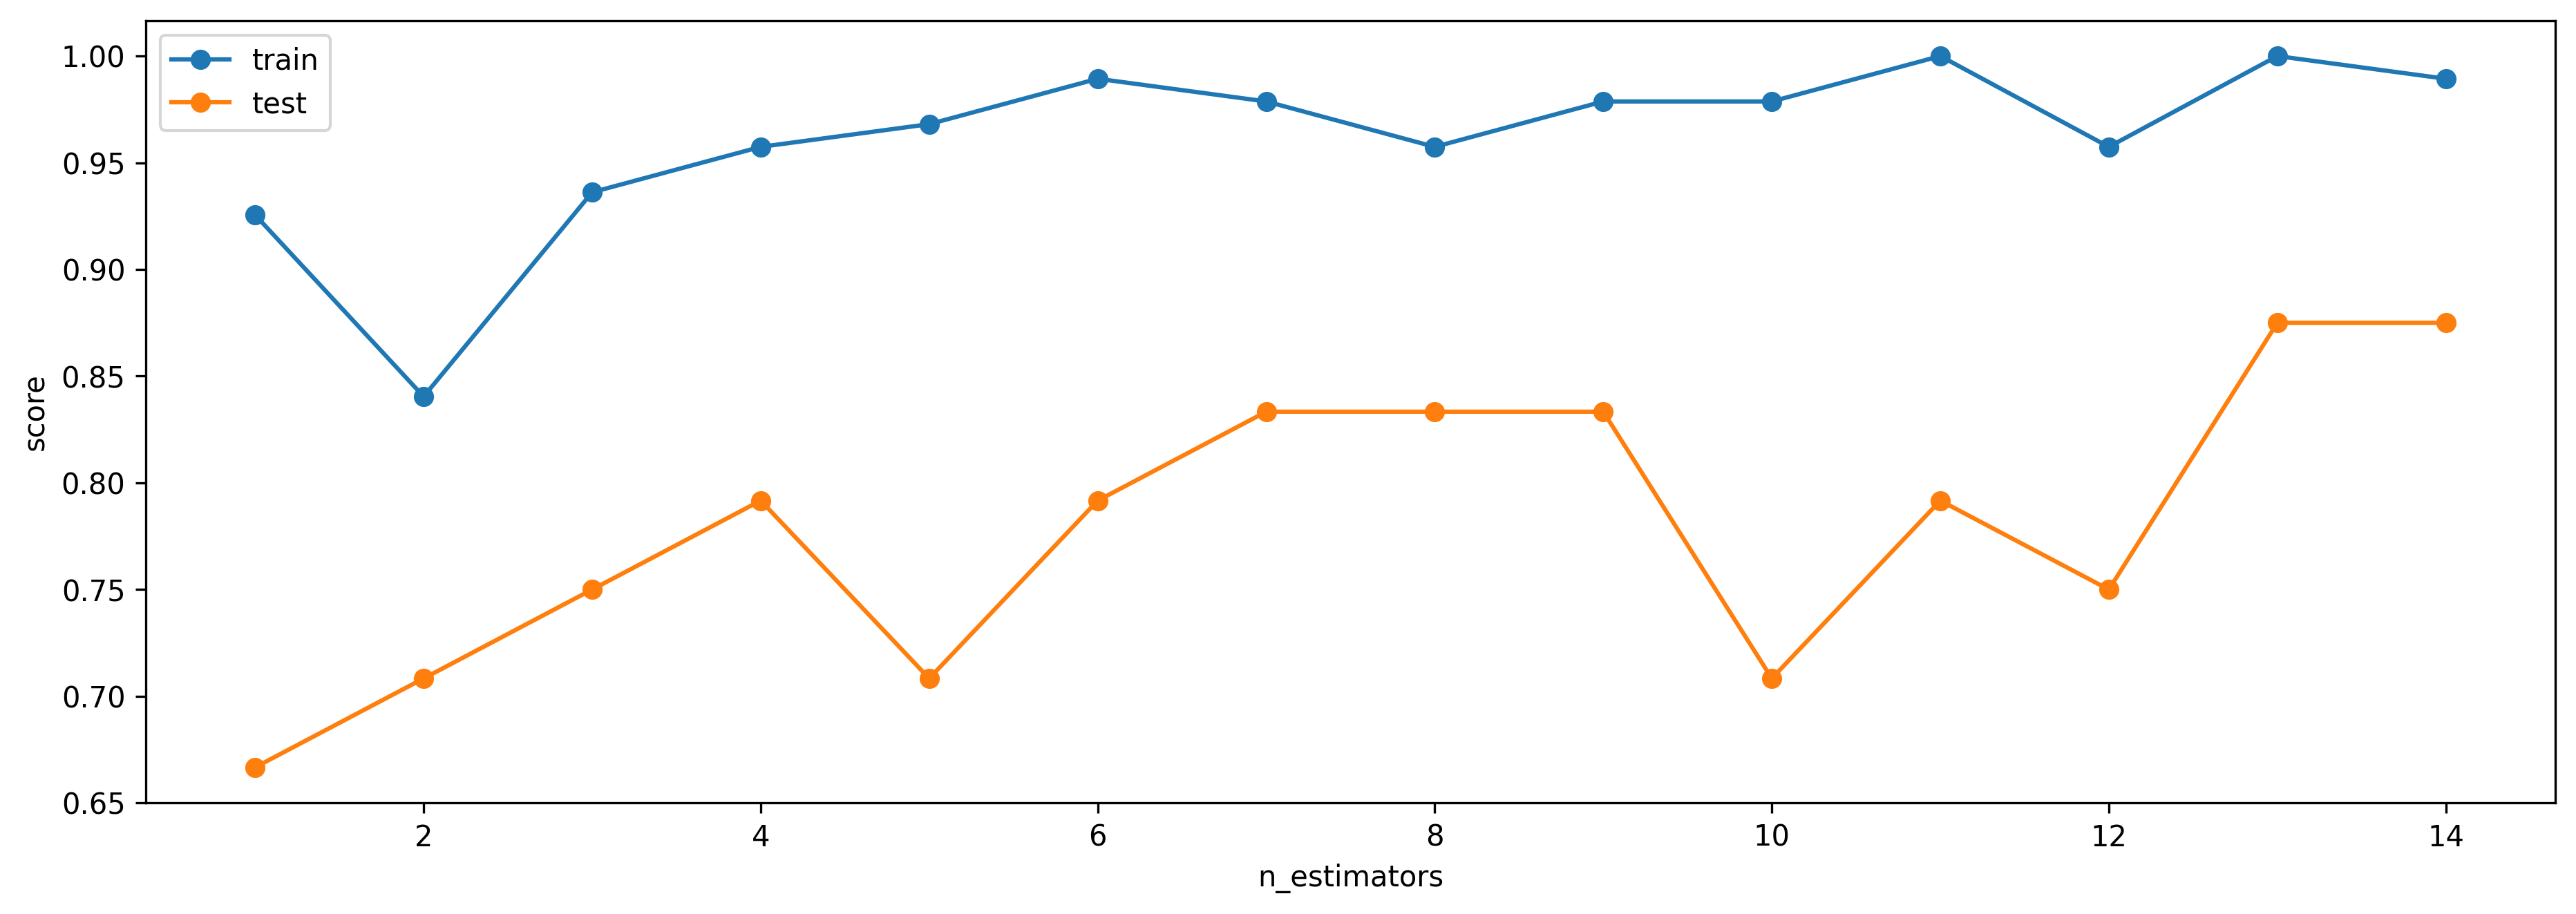

In [164]:
rng = np.random.RandomState(1337)
brute_plot(RandomForestClassifier, all, "n_estimators", np.arange(1, 15), random_state=rng, max_depth=11)

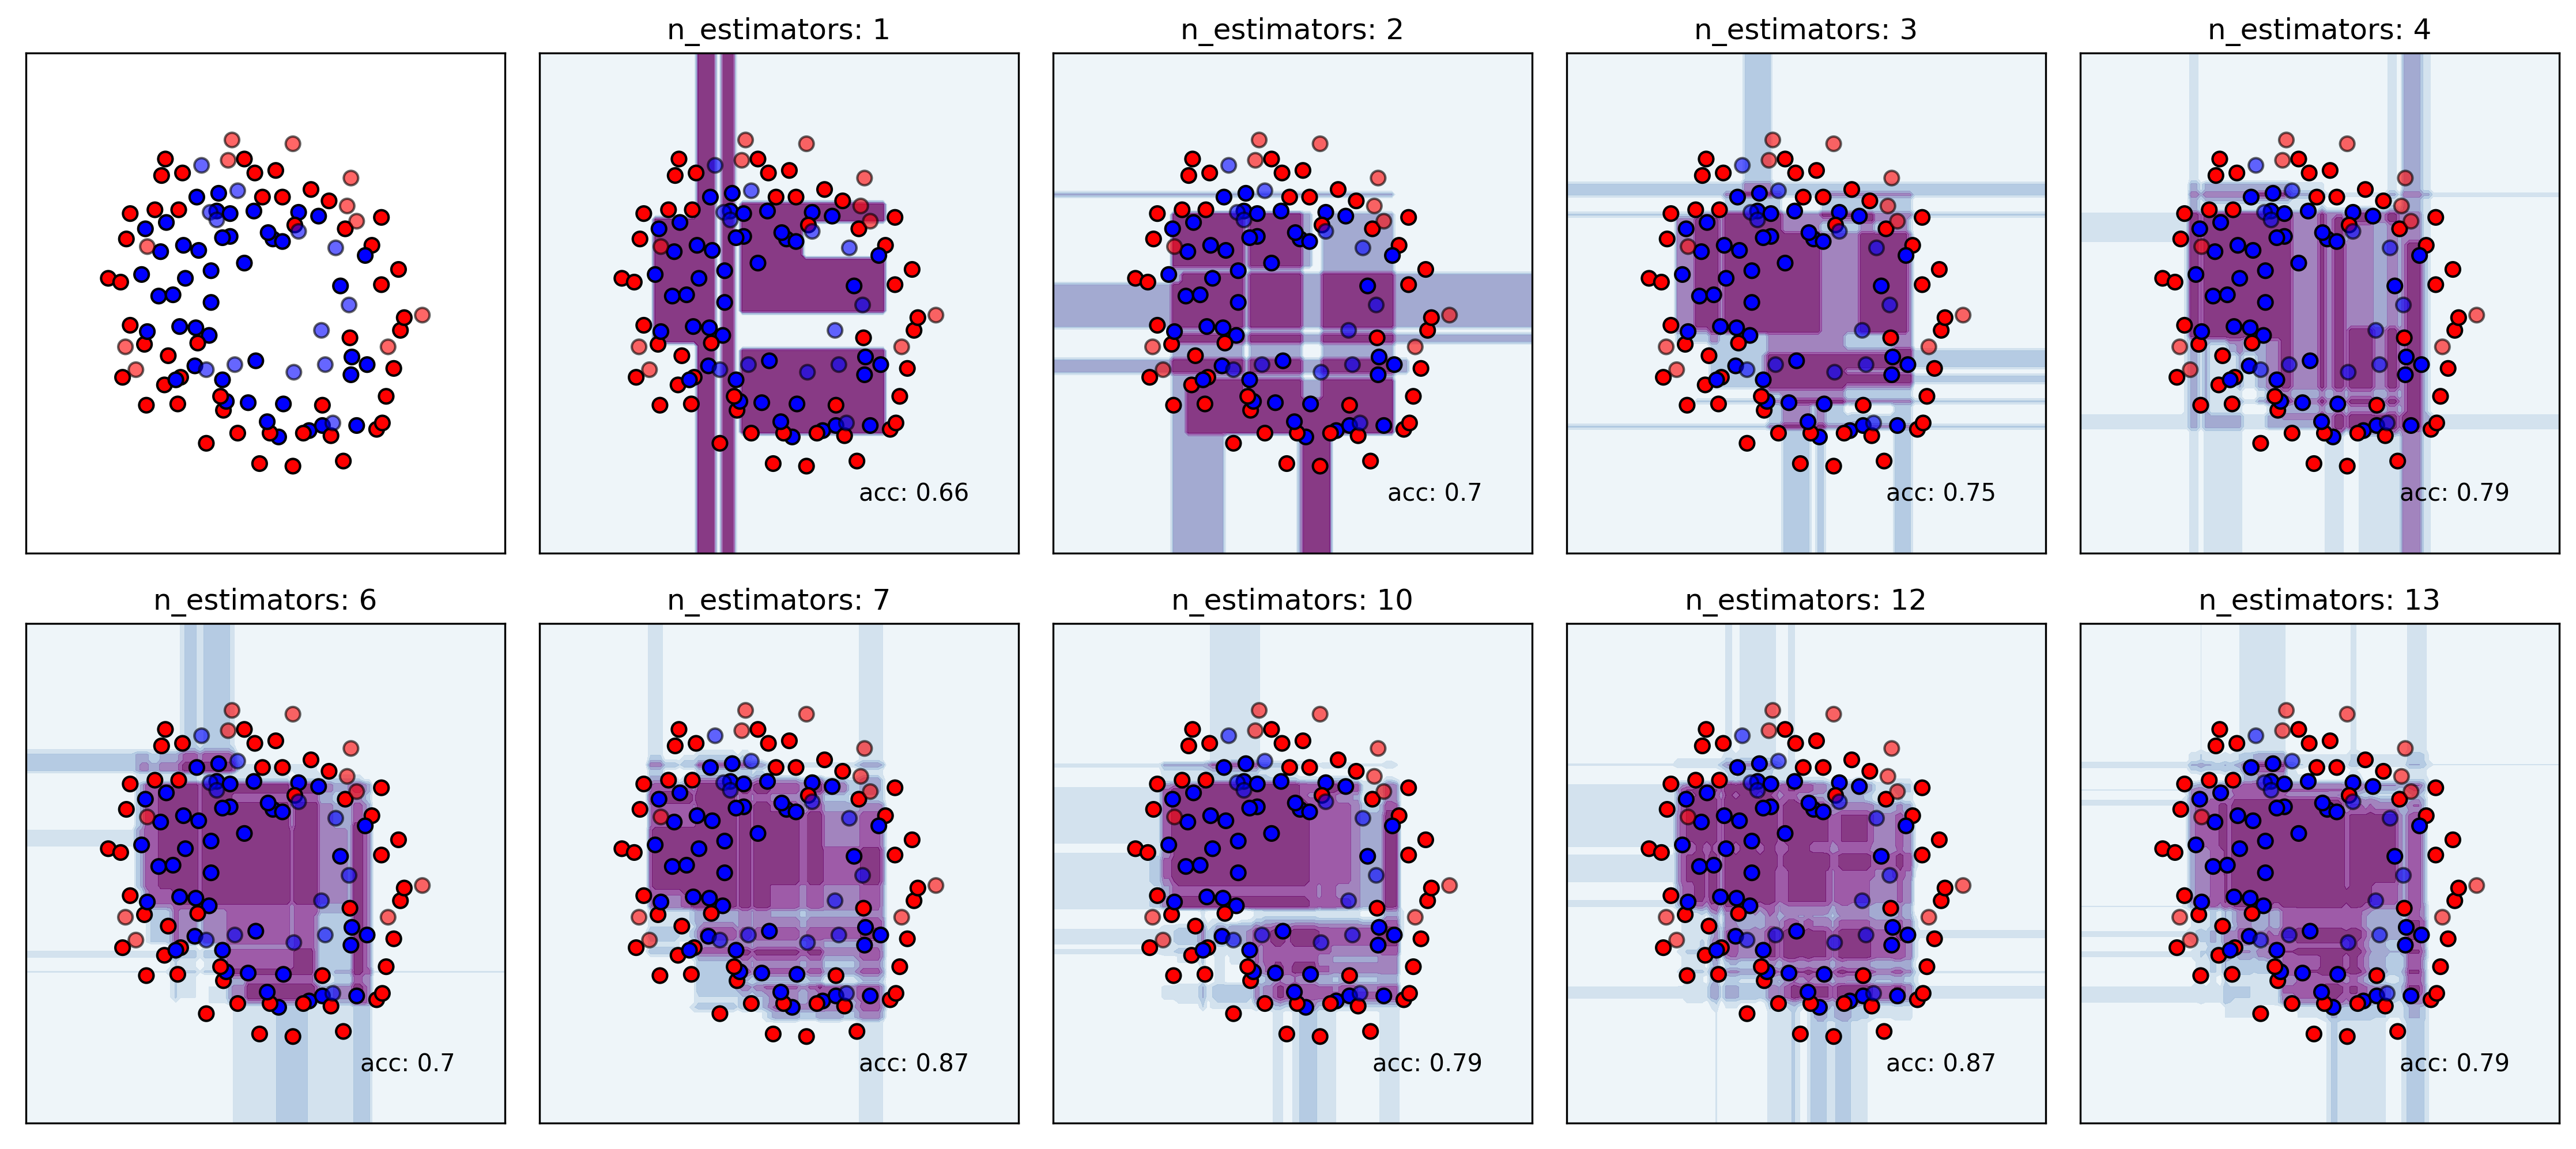

In [167]:
rng = np.random.RandomState(1337)
space_plot(RandomForestClassifier, all, "n_estimators", [1, 2, 3, 4, 6, 7, 10, 12, 13], random_state=rng, max_depth=11)

# Gradient boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

best scores: train=1.0, test=0.8333333333333334


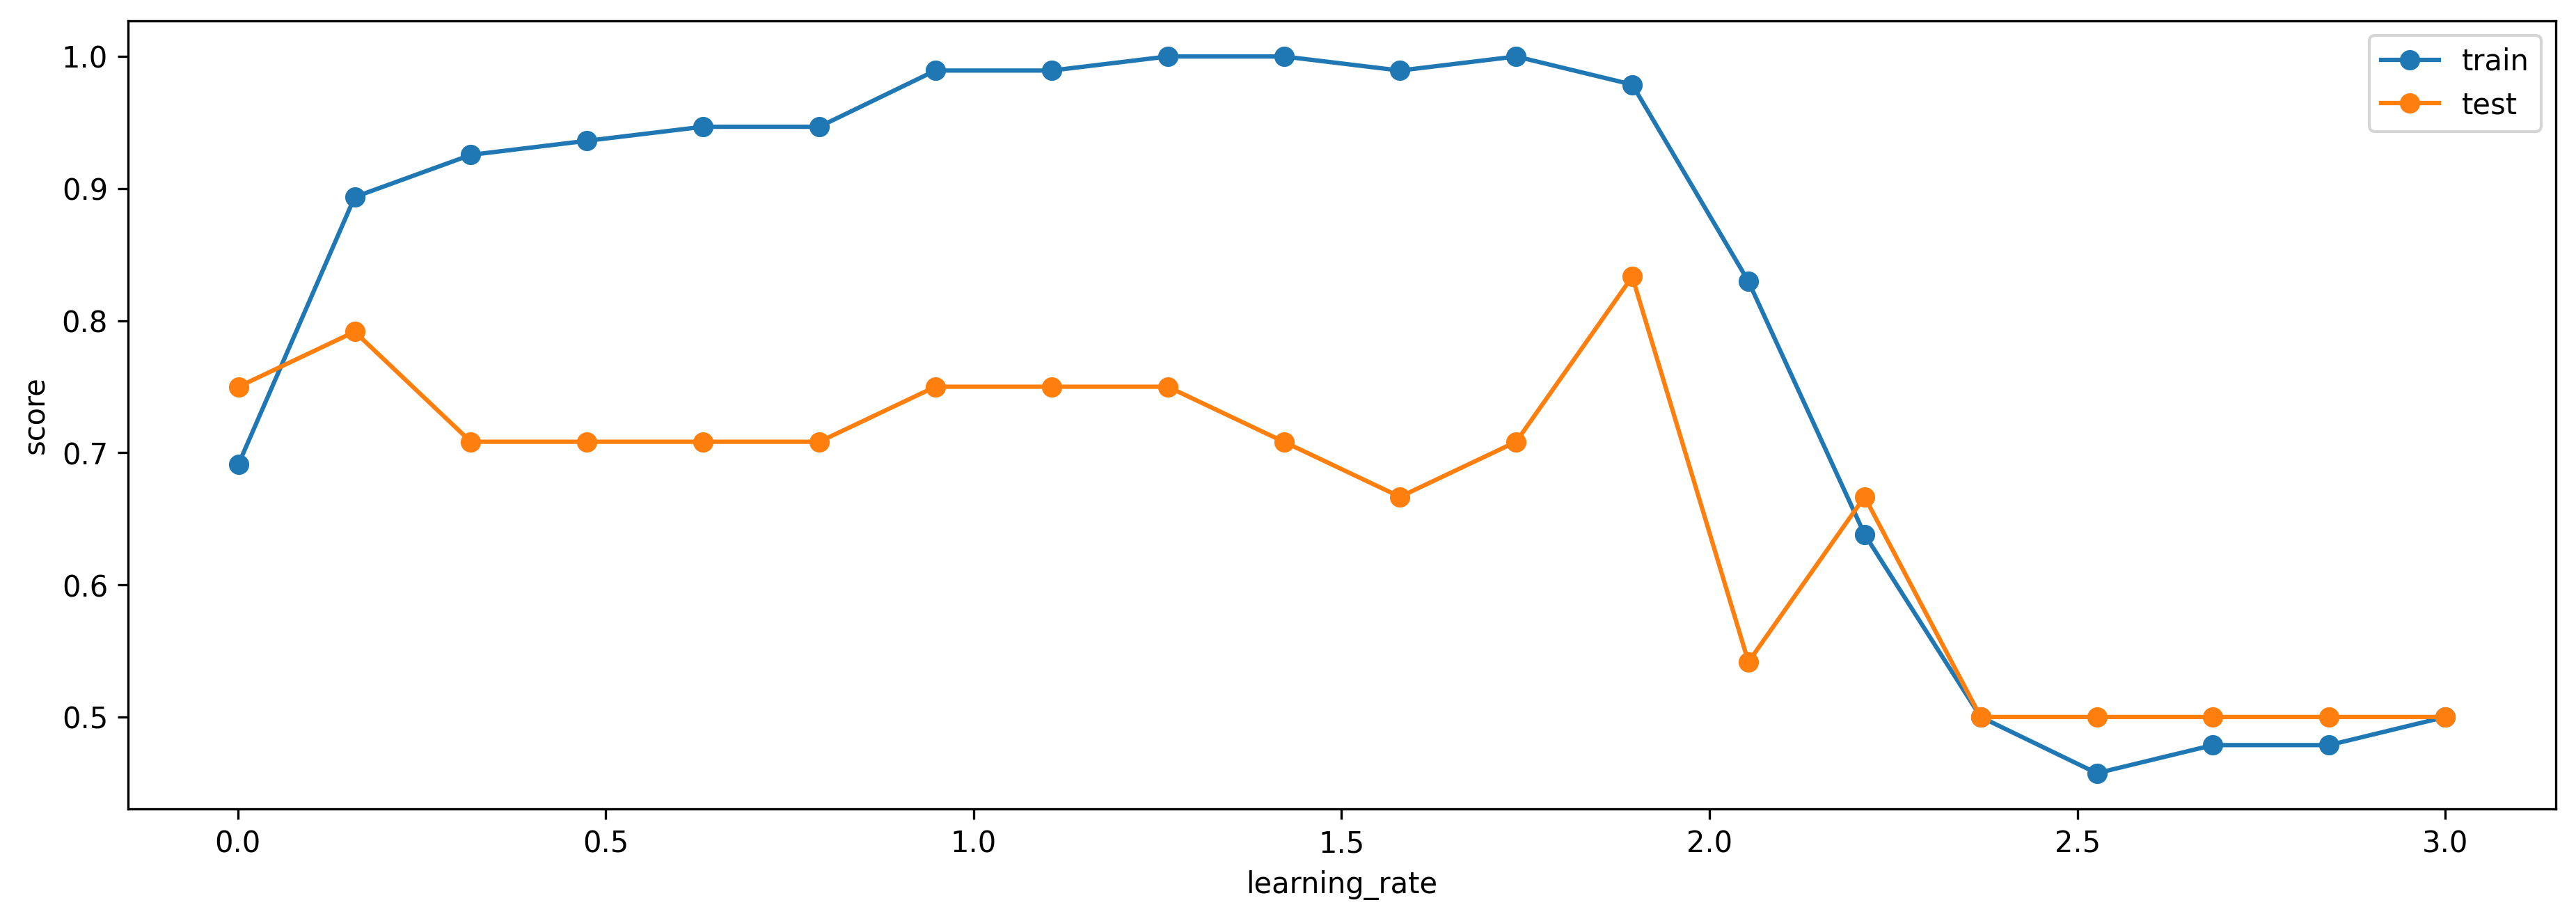

In [179]:
rng = np.random.RandomState(1337)
brute_plot(AdaBoostClassifier, all, "learning_rate", np.linspace(0.001, 3, 20), random_state=rng)

best scores: train=1.0, test=0.875


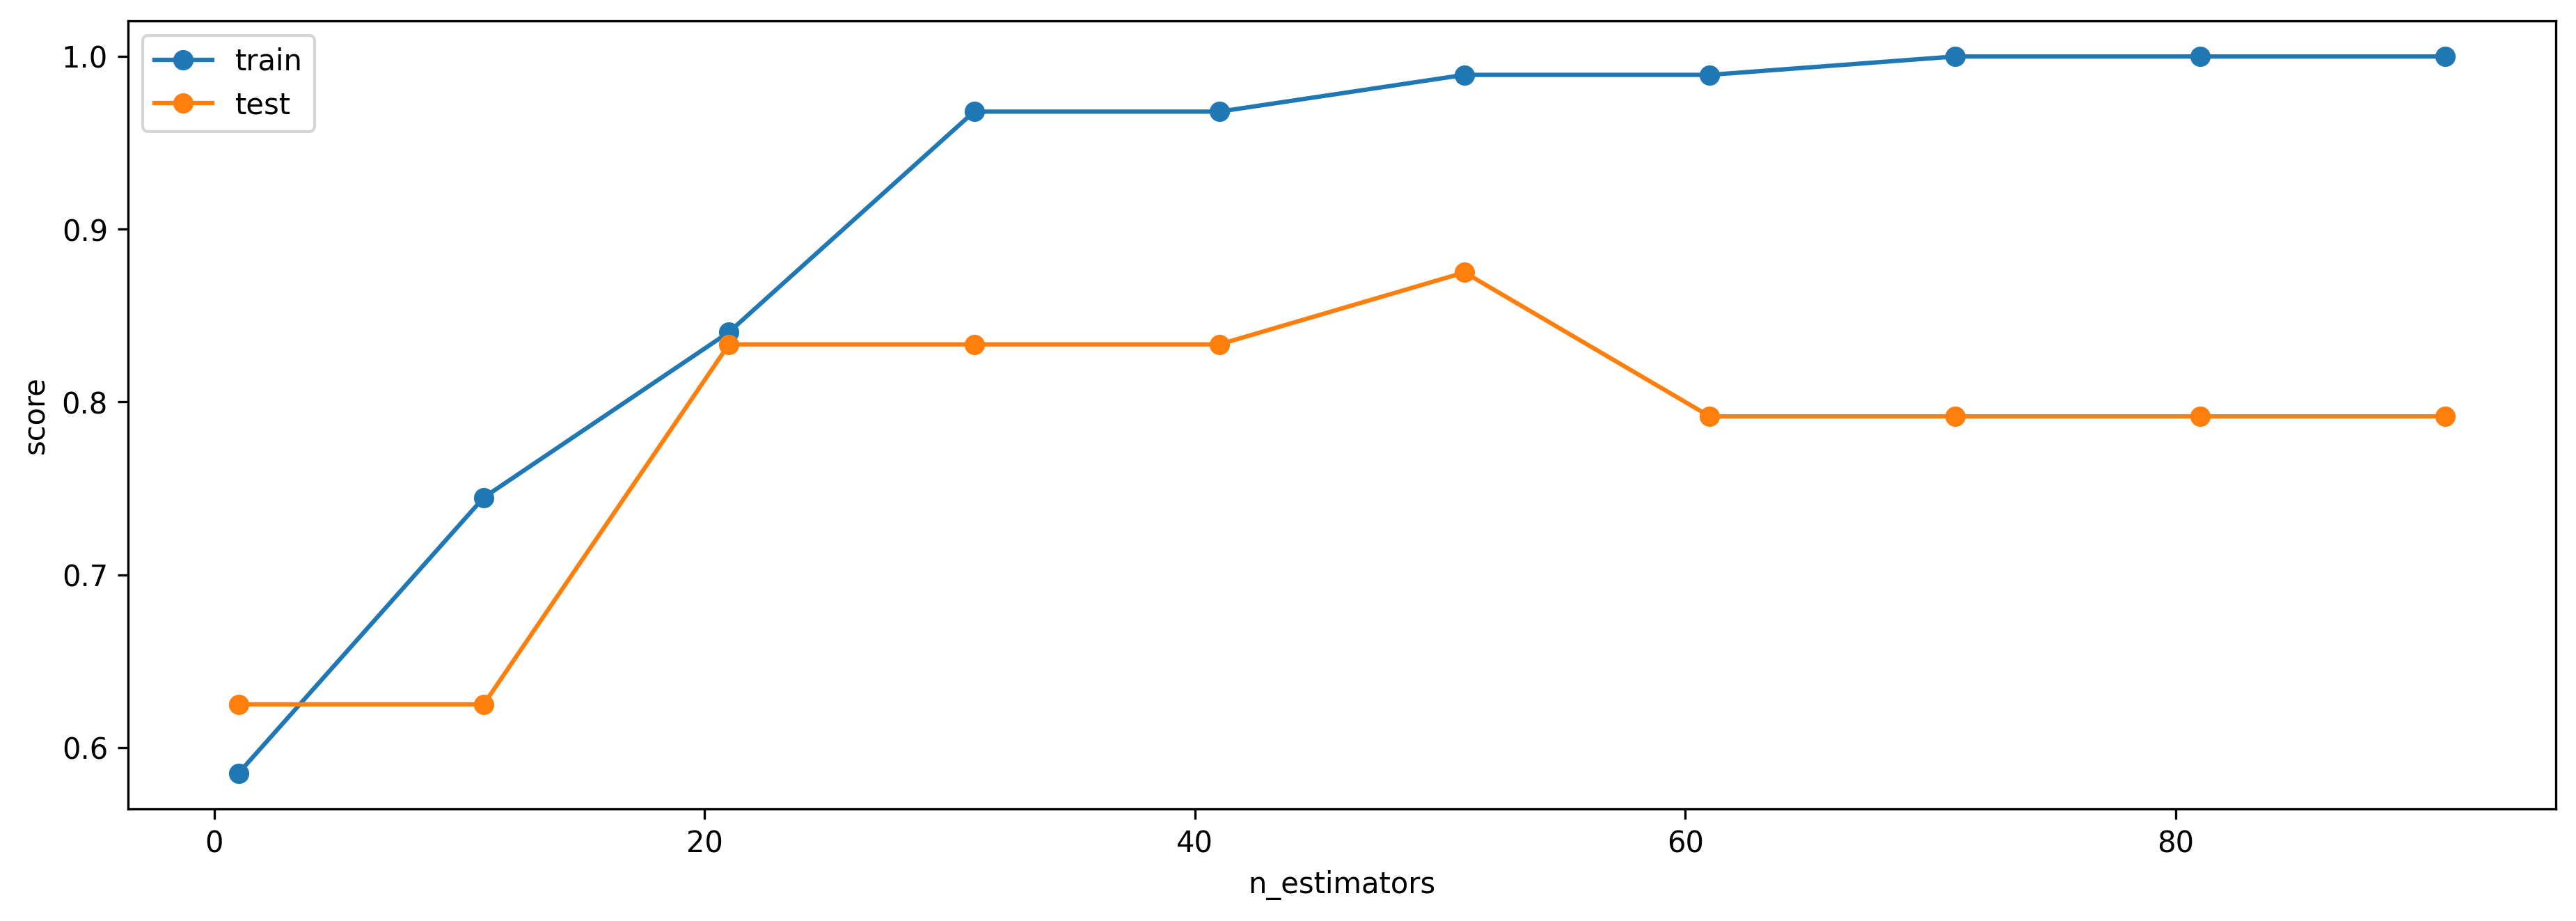

In [188]:
rng = np.random.RandomState(1337)
brute_plot(AdaBoostClassifier, all, "n_estimators", np.arange(1, 100, 10), random_state=rng, learning_rate=1.89)

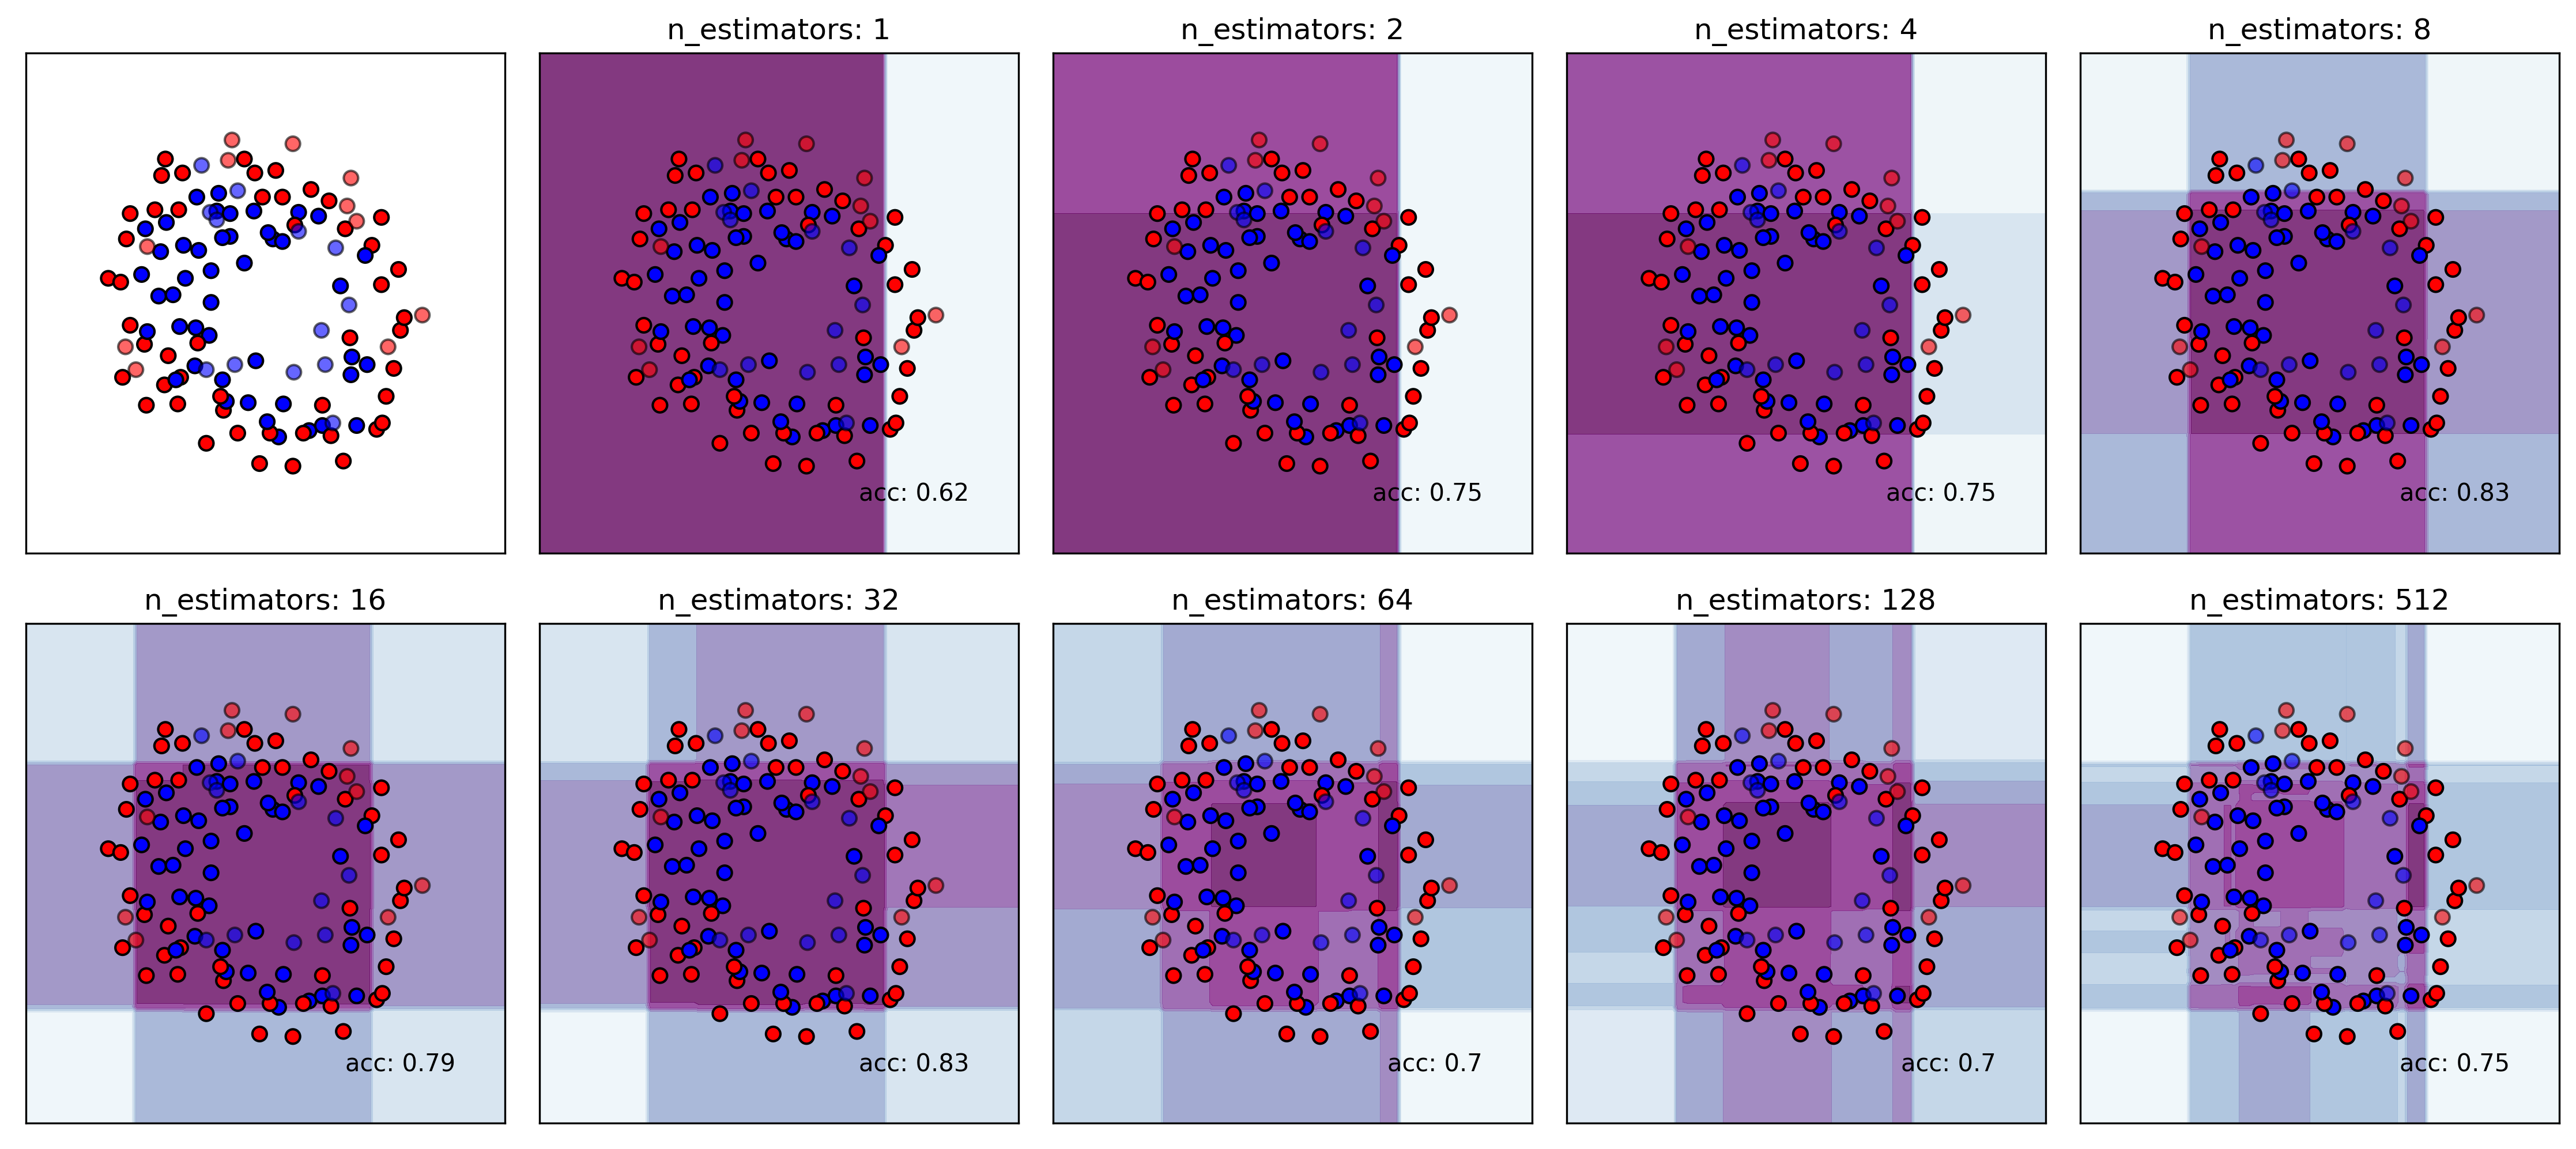

In [185]:
rng = np.random.RandomState(1337)
space_plot(AdaBoostClassifier, all, "n_estimators", [1, 2, 4, 8, 16, 32, 64, 128, 512], random_state=rng, learning_rate=0.158)